In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from astropy.table import Table
import warnings
warnings.simplefilter("ignore")

- [The Catalog site](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilgrb&Action=More+Options)
- [Feature key](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html)

You can check a burst's GBM detectors by putting its name into the [GRB burst catalog](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermigbrst&Action=More+Options) and selecting the data products option "D".

--- 

- FullCatalog.fits holds ALL GRB sources contained in the 2nd Fermi-LAT GRB Catalog
- RS=null.fits holds GRBs which have a null in the redshift parameter
---
\tableofcontents

In [17]:
### Helper functions -- always run this cell

def clean_data(targets):
    # Cleans columns & GRB names
    
    # Remove trailing whitespace
    targets = targets.rename(columns=lambda x: x.strip().lower())
    # Cleans GRB names
    targets['name'] = targets['name'].str.decode("utf-8").replace('\'','').replace(r"^ +| +$", r"", regex=True)[1:]
    return targets

def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

def calculate_hardness(targets):
    # Calculates flux, flux_ene & fluence ratios with corresponding error
    targets['flux_ratio'] = targets['like_gbm_flux']/targets['like_lat_flux']
    targets['flux_ene_ratio'] = targets['like_gbm_flux_ene']/targets['like_lat_flux_ene']
    targets['fluence_ratio'] = targets['like_gbm_fluence']/targets['like_lat_fluence']
    targets['hardness'] = targets['like_lat_fluence']/targets['like_gbm_fluence']



    targets['flux_ratio_error'] = propagate_error(targets['like_gbm_flux'],
                                                  targets['like_lat_flux'],
                                                  targets['like_gbm_flux_error'],
                                                  targets['like_lat_flux_error'])

    targets['flux_ene_ratio_error'] = propagate_error(targets['like_gbm_flux_ene'],
                                                      targets['like_lat_flux_ene'],
                                                      targets['like_gbm_flux_ene_error'],
                                                      targets['like_lat_flux_ene_error'])

    targets['fluence_ratio_error'] = propagate_error(targets['like_gbm_fluence'],
                                                      targets['like_lat_fluence'],
                                                      targets['like_gbm_fluence_error'],
                                                      targets['like_lat_fluence_error'])
    
    targets['hardness_error'] = propagate_error(targets['like_lat_fluence'],
                                                targets['like_gbm_fluence'],
                                                targets['like_lat_fluence_error'],
                                                targets['like_gbm_fluence_error'])
    return targets

def calculate_time_difference(targets):
    # Calculate like & gbm-lle time differences
    targets['like_gbm-lat_time_difference'] = targets['like_gbm_t0'] - targets['like_lat_t0']
    targets['gbm-lle_t90_difference'] = targets['gbm_cat_t90'] - targets['lle_t90']
    return targets

# Starting with just RS=null datset

Let's start with the RS=null dataset & take a look at hardness vs. burst duration and angular density.

In [87]:
# Load the RS=null.fits dataset
dat = Table.read('RS=null.fits')
all_candidates = dat.to_pandas()

# Cleaning data
all_candidates = clean_data(all_candidates)
all_candidates = calculate_hardness(all_candidates)
all_candidates = calculate_time_difference(all_candidates)

all_candidates.info()

all_candidates.T.tail(8).T.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Columns: 117 entries, name to gbm-lle_t90_difference
dtypes: float64(111), int16(2), object(4)
memory usage: 168.0+ KB


,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_t90_difference
count,179.0,179.0,128.0,128.0,128.0,128.0,186.0,186.0
unique,130.0,130.0,115.0,115.0,115.0,115.0,178.0,181.0
top,0.0,inf,0.0,0.0,0.0,0.0,0.0,60.0
freq,43.0,43.0,14.0,14.0,14.0,14.0,7.0,3.0


The original method simply extracted all sources with a gbm-lat_time_difference > 0.

In [83]:
original_targets = all_candidates.copy()[ all_candidates['like_gbm-lat_time_difference'] > 0 ]

original_targets[['like_gbm-lat_time_difference', 'gbm-lle_t90_difference', 
                  'lle_t90', 'fluence_ratio', 'flux_ratio',
         'flux_ene_ratio', 'hardness', 'tl100', 'Like_LAT_GRBIndex'.lower(), 'gbm_cat_t90']].corr()

,like_gbm-lat_time_difference,gbm-lle_t90_difference,lle_t90,fluence_ratio,flux_ratio,flux_ene_ratio,hardness,tl100,like_lat_grbindex,gbm_cat_t90
like_gbm-lat_time_difference,1.000000,0.902113,0.433862,0.204594,-0.253622,-0.196086,-0.045453,-0.057890,-0.134812,0.902677
gbm-lle_t90_difference,0.902113,1.000000,0.423263,0.284799,-0.241836,-0.159431,-0.119961,0.113244,-0.190975,0.993229
lle_t90,0.433862,0.423263,1.000000,-0.428389,0.419362,0.466163,0.393049,0.647220,-0.142664,0.525654
fluence_ratio,0.204594,0.284799,-0.428389,1.000000,-0.148915,-0.076505,-0.732730,-0.254756,-0.518535,0.218717
flux_ratio,-0.253622,-0.241836,0.419362,-0.148915,1.000000,0.964576,-0.183570,0.682316,0.481620,-0.179171
flux_ene_ratio,-0.196086,-0.159431,0.466163,-0.076505,0.964576,1.000000,-0.235446,0.776726,0.379237,-0.095762
hardness,-0.045453,-0.119961,0.393049,-0.732730,-0.183570,-0.235446,1.000000,0.138811,-0.338282,-0.062238
tl100,-0.057890,0.113244,0.647220,-0.254756,0.682316,0.776726,0.138811,1.000000,-0.064335,0.189323
like_lat_grbindex,-0.134812,-0.190975,-0.142664,-0.518535,0.481620,0.379237,-0.338282,-0.064335,1.000000,-0.197610
gbm_cat_t90,0.902677,0.993229,0.525654,0.218717,-0.179171,-0.095762,-0.062238,0.189323,-0.197610,1.000000


There should be a negative correlation between burst duration and corresponding fluence ratio (0927-6505(96)00018-7, Figure 2.)

(-0.75, 8.0)

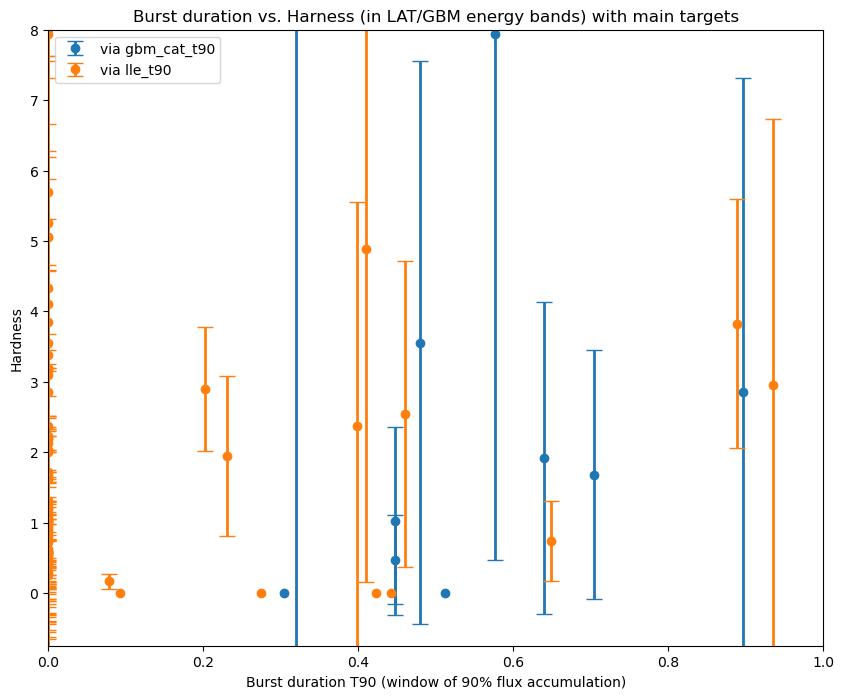

In [55]:
fig, ax = plt.subplots()
ax.errorbar(x = all_candidates['gbm_cat_t90'], y=all_candidates['hardness'], 
            yerr = all_candidates['hardness_error'], fmt = 'o', linewidth = 2, capsize = 6, 
            label = 'via gbm_cat_t90')
ax.errorbar(x = all_candidates['lle_t90'], y=all_candidates['hardness'], 
            yerr = all_candidates['hardness_error'], fmt = 'o', linewidth = 2, capsize = 6, 
            label = 'via lle_t90')

ax.legend()
ax.set_xlabel('Burst duration T90 (window of 90% flux accumulation)')
ax.set_ylabel('Hardness')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Harness (in LAT/GBM energy bands) with main targets')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0,1)
ax.set_ylim(-.75,8)

Try to see if the considered correlation does exist by seeing if there's that negative correlation.

In [56]:
targets = all_candidates.copy()

# Polyfit does not like NaNs or infs
print('Dropping %s targets for inf hardness'% len(targets.loc[targets['hardness'] == np.inf]) )
targets = targets.loc[ targets['hardness'] != np.inf ]
print('Dropping %s targets for NaN hardness'% len(targets.loc[ np.isnan(targets['hardness']) ]) )
targets = targets.loc[ ~np.isnan(targets['hardness']) ]

# These ones will have had a 0.0 in the LAT flux, causing a NaN
print('Dropping %s targets for NaN hardness_error'% len(targets.loc[ np.isnan(targets['hardness_error']) ]) )
targets = targets.loc[ ~np.isnan(targets['hardness_error']) ]

# These ones will have had a 0.0 in GBM flux, causing a 0.
print('Dropping %s targets for 0. hardness_error'%len(targets[targets['hardness_error'] ==0]))
targets = targets[targets['hardness_error'] !=0]

Dropping 43 targets for inf hardness
Dropping 7 targets for NaN hardness
Dropping 8 targets for NaN hardness_error
Dropping 14 targets for 0. hardness_error


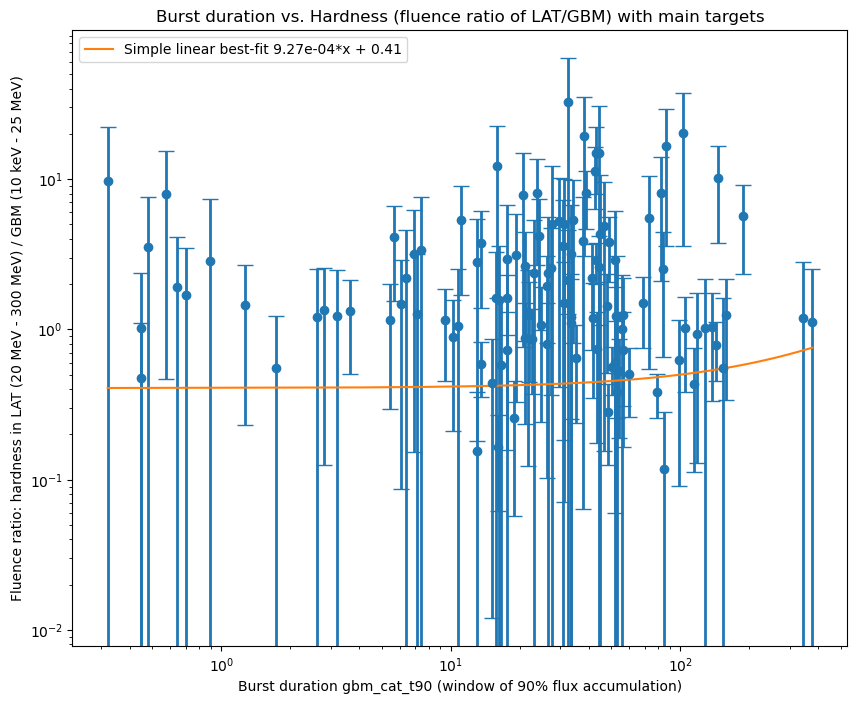

In [57]:
# Fit data with a simple linear correlation
result = np.polyfit(x = targets['gbm_cat_t90'], y = targets['hardness'], 
                 deg = 1, w = 1/targets['hardness_error'], full=True)
fit = result[0]

fig, ax = plt.subplots()
ax.errorbar(x = targets['gbm_cat_t90'], y=targets['hardness'], 
            yerr = targets['hardness_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration gbm_cat_t90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio: hardness in LAT (20 MeV - 300 MeV) / GBM (10 keV - 25 MeV)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Hardness (fluence ratio of LAT/GBM) with main targets')
#ax.set_xscale('log')

stats = targets['gbm_cat_t90'].describe()

time_domain = np.linspace(stats['min'], stats['max'], 100)

ax.plot(time_domain, time_domain*fit[0] + fit[1] 
        , '-', label = 'Simple linear best-fit %.2e*x + %.2f'%(fit[0], fit[1]))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

#plt.figtext(0.5, 0.01, 
#            'Fluence ratio ~= hardness wrt. GBM and LAT -- GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)', 
#            horizontalalignment='center', fontsize=9)

In [58]:
fig.savefig('Burst_duration_vs_hardness.png')

Time to focus a little on their angular distribution. Since the candidates aren't parsed down, the distribution won't mean too much. I'm curious, though, whether Cline's anomalous overdense region shows up.

In [59]:

def generate_mollweise(targets, log_hardness = False, burst_duration_col='lle_t90', calculate_isotropy=True):

    fig = plt.figure()
    ax1 = fig.add_subplot(211, projection='mollweide')
    plt.grid(True)
    ax2 = fig.add_subplot(212, projection='mollweide')
    plt.grid(True)

    # change the >180s to negative
    modified = targets.copy()
    modified.loc[modified['lii']>180, 'lii'] -= (360)

    fig.set_figwidth(20)
    fig.set_figheight(11)
    
    if log_hardness is True:
        modified['hardness'] = np.log(modified['hardness'])
        ax1.set_title('log(Hardness): darker  = harder')
    else:
        ax1.set_title('Hardness: darker  = harder')
    ax1.scatter(modified['lii']*(np.pi/180), targets['bii']*(np.pi/180), 50, 
                c=modified['hardness'], cmap='Greens', edgecolors='lightgray')

    # quick parse-out of the 0 t90s
    nonzeros = targets[ targets[burst_duration_col]!=0.0 ]
    modified = modified[ targets[burst_duration_col]!=0.0 ]

    ax2.set_title('log(1/Burst Duration): darker = shorter')#, rotation=-90, position=(1, .5), ha='left', va='center')
    ax2.scatter(modified['lii']*(np.pi/180), modified['bii']*(np.pi/180), 50, 
                c=np.log10(1/nonzeros[burst_duration_col]), cmap='Greens', edgecolors='lightgray')

    ax1.set_ylabel('Gal. Longitude')
    ax2.set_xlabel('Gal. Latitude')

    caption = 'In Gal. Lat/Long coords, the galactic center is at (0,0) and the plane is on the x-axis.'
    
    if calculate_isotropy:
        #### TODO
        center = modified.query('lii > -90 and lii < 90').shape[0]
        anticenter = modified.query('lii > 90 or lii < -90').shape[0]
        caption += '\ncenter/anticenter numerical ratio of %.2f'%(center/anticenter)
        northern = modified.query('bii > 0 and bii < 90').shape[0]
        southern = modified.query('bii < 0 and bii > -90').shape[0]
        caption += '\nnothern/southern num. ratio of %.2f'%(northern/southern)
    
    plt.figtext(0.5, 0.01, 
                caption, 
                horizontalalignment='center', fontsize=10)
    return fig

#fig = generate_mollweise(targets)

#fig.savefig('AngularDistribution.png')

---

# Now with the full dataset

Let's try to enforce the same restrictions that Cline did on their BATSE data.

- Hardness >0
- Burst Duration <1s

Also, we need to figure out a way to determine the actual burst duration in the way that Cline did.

In [18]:
# Load the FullCatalog.fits dataset
dat = Table.read('FullCatalog.fits')
all_candidates = dat.to_pandas()

# Cleaning data
all_candidates = clean_data(all_candidates)
all_candidates = calculate_hardness(all_candidates)
all_candidates = calculate_time_difference(all_candidates)

all_candidates.info()

all_candidates.T.tail(8).T.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Columns: 117 entries, name to gbm-lle_t90_difference
dtypes: float64(111), int16(2), object(4)
memory usage: 208.6+ KB


,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_t90_difference
count,223.0,223.0,157.0,157.0,157.0,157.0,231.0,231.0
unique,159.0,159.0,143.0,143.0,143.0,143.0,222.0,226.0
top,0.0,inf,0.0,0.0,0.0,0.0,0.0,60.0
freq,58.0,58.0,15.0,15.0,15.0,15.0,8.0,3.0


In [97]:
# Do we want the ones with the highest hardness value?
print('Sorted by hardness: ')
print(all_candidates[['hardness', 'name', 'ra', 'dec', 'lle_t90', 'gbm_cat_t90', 'gbm-lle_t90_difference']].loc[all_candidates[
    'hardness'] != np.inf].sort_values(by='hardness', ascending=False).head(20))


# I want to get the smallest burst-duration one too
print('\nSorted by LLE burst duration:')
print(all_candidates[ all_candidates['lle_t90']!=0.0 ][[
    'lle_t90', 'name', 'ra', 'dec', 'hardness', 'gbm_cat_t90', 'gbm-lle_t90_difference']].sort_values(
    by = 'lle_t90', ascending=True).head(20))

print('\nSorted by GBM burst duration:')
print(all_candidates[['gbm_cat_t90', 'name', 'ra', 'dec', 'hardness', 'lle_t90', 'gbm-lle_t90_difference']].sort_values(
    by = 'gbm_cat_t90', ascending=True).head(20))

Sorted by hardness: 
      hardness          name       ra     dec  lle_t90  gbm_cat_t90  \
115  92.767876  GRB131231198   10.550  -1.720   12.796       31.232   
34   32.573197  GRB220408311   92.480 -50.970    0.000       32.513   
144  20.354248  GRB100116897  305.000  14.510    6.657      102.530   
47   19.184728  GRB190531840   24.390 -41.950    6.702       38.145   
98   16.462146  GRB130821674  314.230 -11.520    9.275       87.041   
189  14.992157  GRB160821857  171.290  42.290   34.923       43.009   
157  14.962628  GRB171120556  163.820  22.410    0.000       44.062   
150  13.230824  GRB090323002  190.750  17.070   86.177      133.890   
1    12.136621  GRB190731943  340.310 -76.420    6.354       15.872   
117  11.353343  GRB100511035  111.380  -0.990    0.000       42.433   
113  11.165293  GRB180720598    0.590  -2.950   30.555       48.897   
103  10.138404  GRB140206275  315.240  -8.790   27.601      146.690   
131   9.669260  GRB140402007  207.660   5.970    1.546  

In [98]:
all_lt_2 = all_candidates.query('gbm_cat_t90<2 or lle_t90<2')#.to_csv('<2s_t90_dataset.csv')

                        gbm_cat_t90   lle_t90  hardness  redshift  \
gbm_cat_t90                1.000000 -0.044716 -0.068406  0.133772   
lle_t90                   -0.044716  1.000000 -0.038515  0.011062   
hardness                  -0.068406 -0.038515  1.000000  0.058853   
redshift                   0.133772  0.011062  0.058853  1.000000   
gbm-lle_t90_difference     0.999957 -0.054011 -0.067803  0.133608   

                        gbm-lle_t90_difference  
gbm_cat_t90                           0.999957  
lle_t90                              -0.054011  
hardness                             -0.067803  
redshift                              0.133608  
gbm-lle_t90_difference                1.000000  


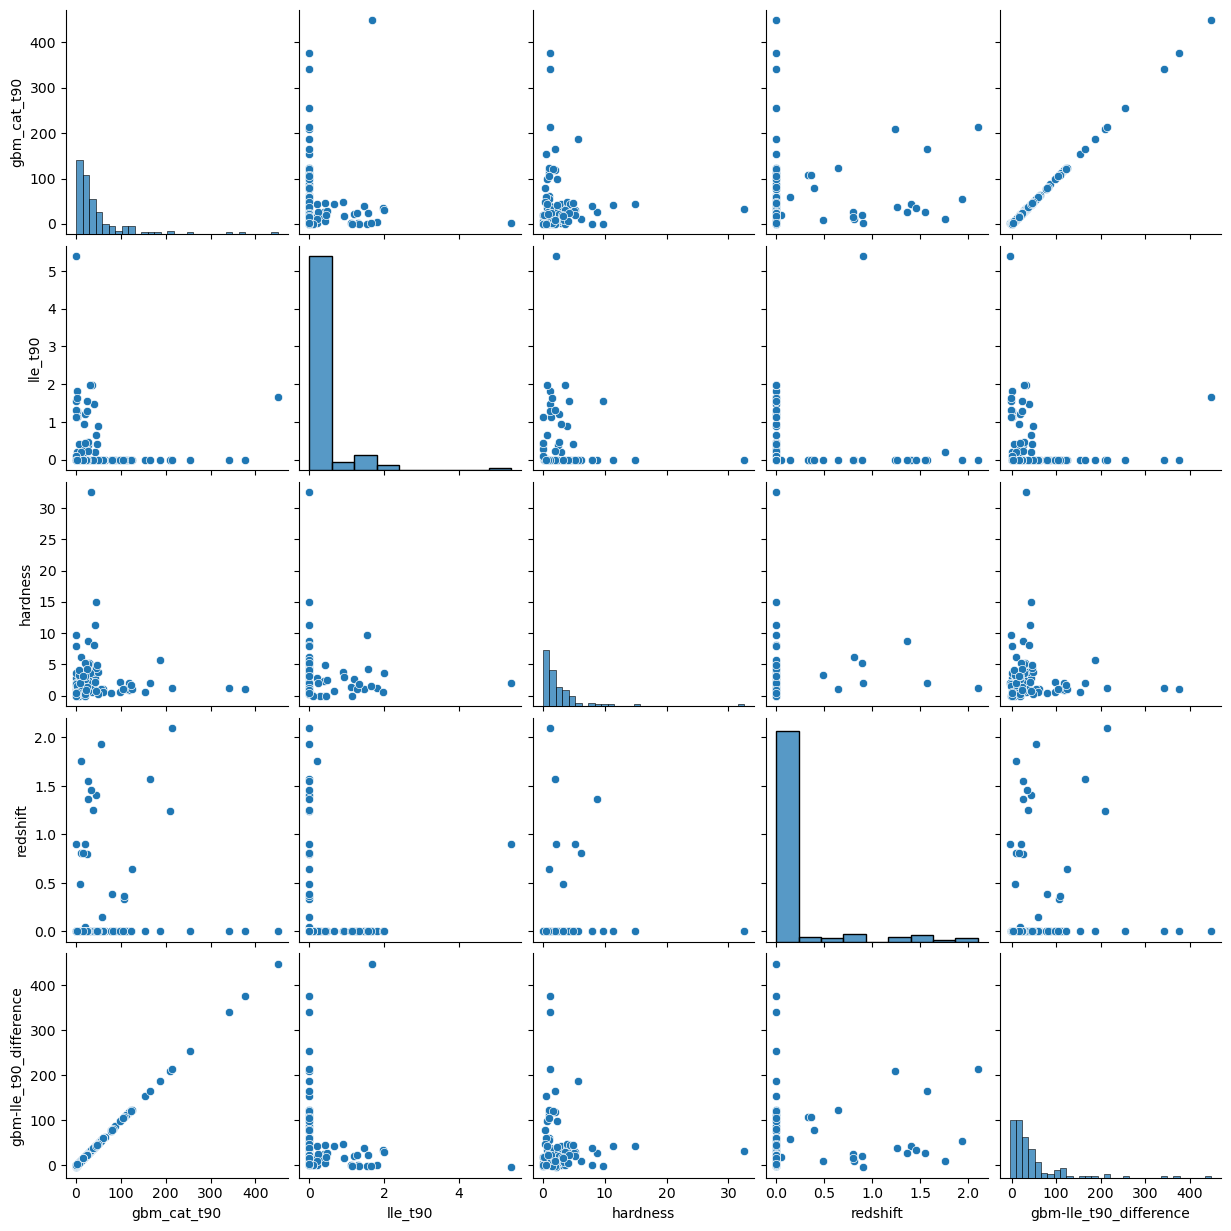

In [99]:
keep_cols = ['gbm_cat_t90','lle_t90','hardness', 'redshift', 'gbm-lle_t90_difference']

print(all_lt_2[keep_cols].corr())
sns.pairplot(all_lt_2[keep_cols])

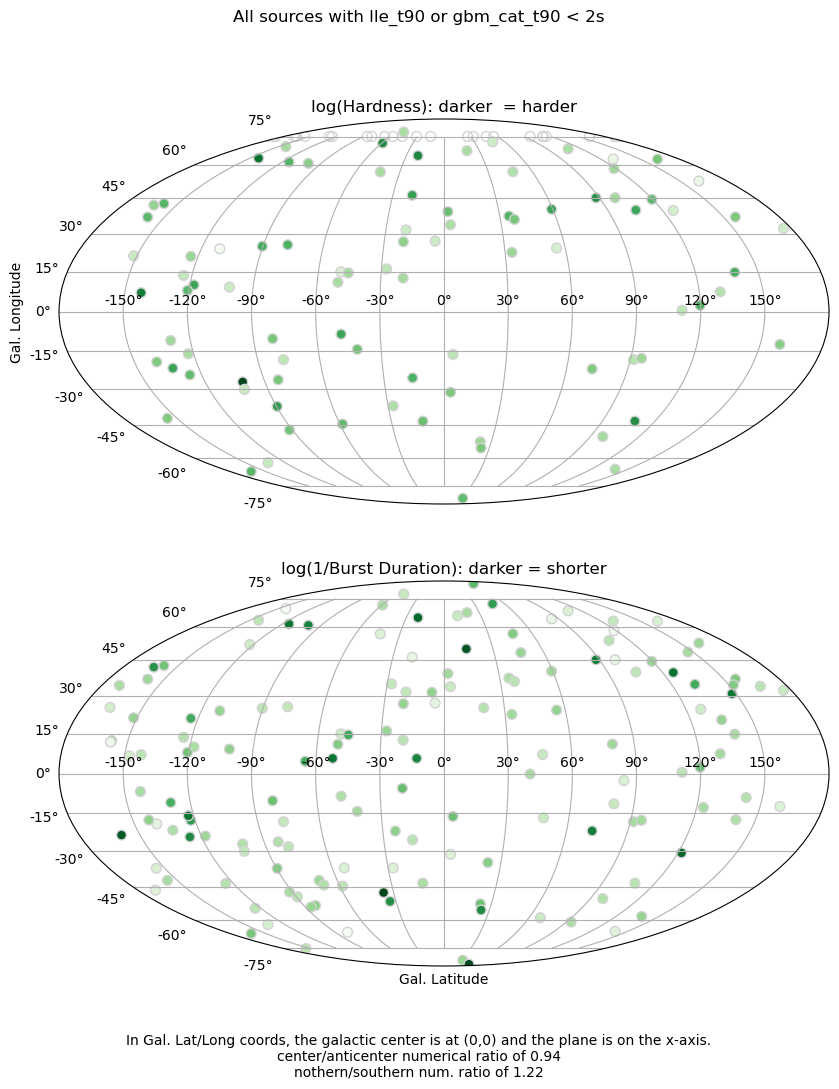

In [100]:
# Generally pretty isotropic, somehow also outside of the galactic plane

fig = generate_mollweise(all_lt_2, log_hardness=True, burst_duration_col='gbm_cat_t90', calculate_isotropy=True)
fig.suptitle('All sources with lle_t90 or gbm_cat_t90 < 2s')
fig.savefig('t90<2sAngularDistribution.png')

---
---
---

In [101]:
# The ones with decent signal
cols = ['name', 'ra', 'dec', 'lle_t90', 'gbm_cat_t90', 'hardness', 'gbm-lle_t90_difference', 'like_gbm-lat_time_difference', 'like_gbm_ts']

all_candidates.query('name in ["GRB141222298", "GRB090227772", "GRB110529034", "GRB131014215"]')[cols]

,name,ra,dec,lle_t90,gbm_cat_t90,hardness,gbm-lle_t90_difference,like_gbm-lat_time_difference,like_gbm_ts
25,GRB141222298,178.00,-57.31,1.293,2.752,inf,1.459,-34.210,0.00000
85,GRB131014215,100.78,-20.76,1.811,3.200,1.224058,1.389,-0.890,131.94600
175,GRB090227772,11.80,32.20,1.144,0.304,0.000000,-0.840,-0.016,23.12530
219,GRB110529034,118.33,67.91,0.093,0.512,0.000000,0.419,-0.128,9.55798


In [102]:
#Sources that Connor likes

keep_cols = ['name', 'lii', 'bii', 'lle_t90', 'gbm_cat_t90', 'hardness', 'gbm-lle_t90_difference', 'like_gbm-lat_time_difference', 'like_gbm_ts'] #'ra', 'dec'

#top = [ "GRB190606080" , "GRB141222298" , "GRB131014215" , "GRB090227772" ]
#tot = [ "GRB150314205" , "GRB131216081" , "GRB110120666" , "GRB090510016" ,
#       "GRB110921912" ] + top + ["GRB110529034"]

selection = ["GRB170127067","GRB141102536","GRB200415367","GRB200219998","GRB210306162","GRB160521385","GRB200219317",
           "GRB210202841","GRB131014215","GRB081009140","GRB110428388","GRB141222298","GRB180703949","GRB130325203",
           "GRB170522657","GRB110529034","GRB090720710","GRB120830297","GRB130310840","GRB200716957","GRB170728961",
           "GRB100620119","GRB090228204","GRB190606080","GRB090227772","GRB081224887","GRB160422499","GRB110921912",
           "GRB110120666","GRB170228794","GRB080825593","GRB181120265","GRB210802839"]
#top = all_candidates.query( 'name in @top' )#[keep_cols]
#tot = all_candidates.query( 'name in @tot' )#[keep_cols]
selection = all_candidates.query( 'name in @selection' )

print(selection[keep_cols].corr())

                                   lii       bii   lle_t90  gbm_cat_t90  \
lii                           1.000000 -0.289301 -0.091364    -0.379257   
bii                          -0.289301  1.000000 -0.132292     0.189471   
lle_t90                      -0.091364 -0.132292  1.000000    -0.090731   
gbm_cat_t90                  -0.379257  0.189471 -0.090731     1.000000   
hardness                     -0.247104  0.073005 -0.019263     0.101228   
gbm-lle_t90_difference       -0.375362  0.192802 -0.120102     0.999564   
like_gbm-lat_time_difference  0.008580  0.298071  0.120298    -0.021865   
like_gbm_ts                   0.004355  0.012600  0.591505     0.011539   

                              hardness  gbm-lle_t90_difference  \
lii                          -0.247104               -0.375362   
bii                           0.073005                0.192802   
lle_t90                      -0.019263               -0.120102   
gbm_cat_t90                   0.101228                0.9995

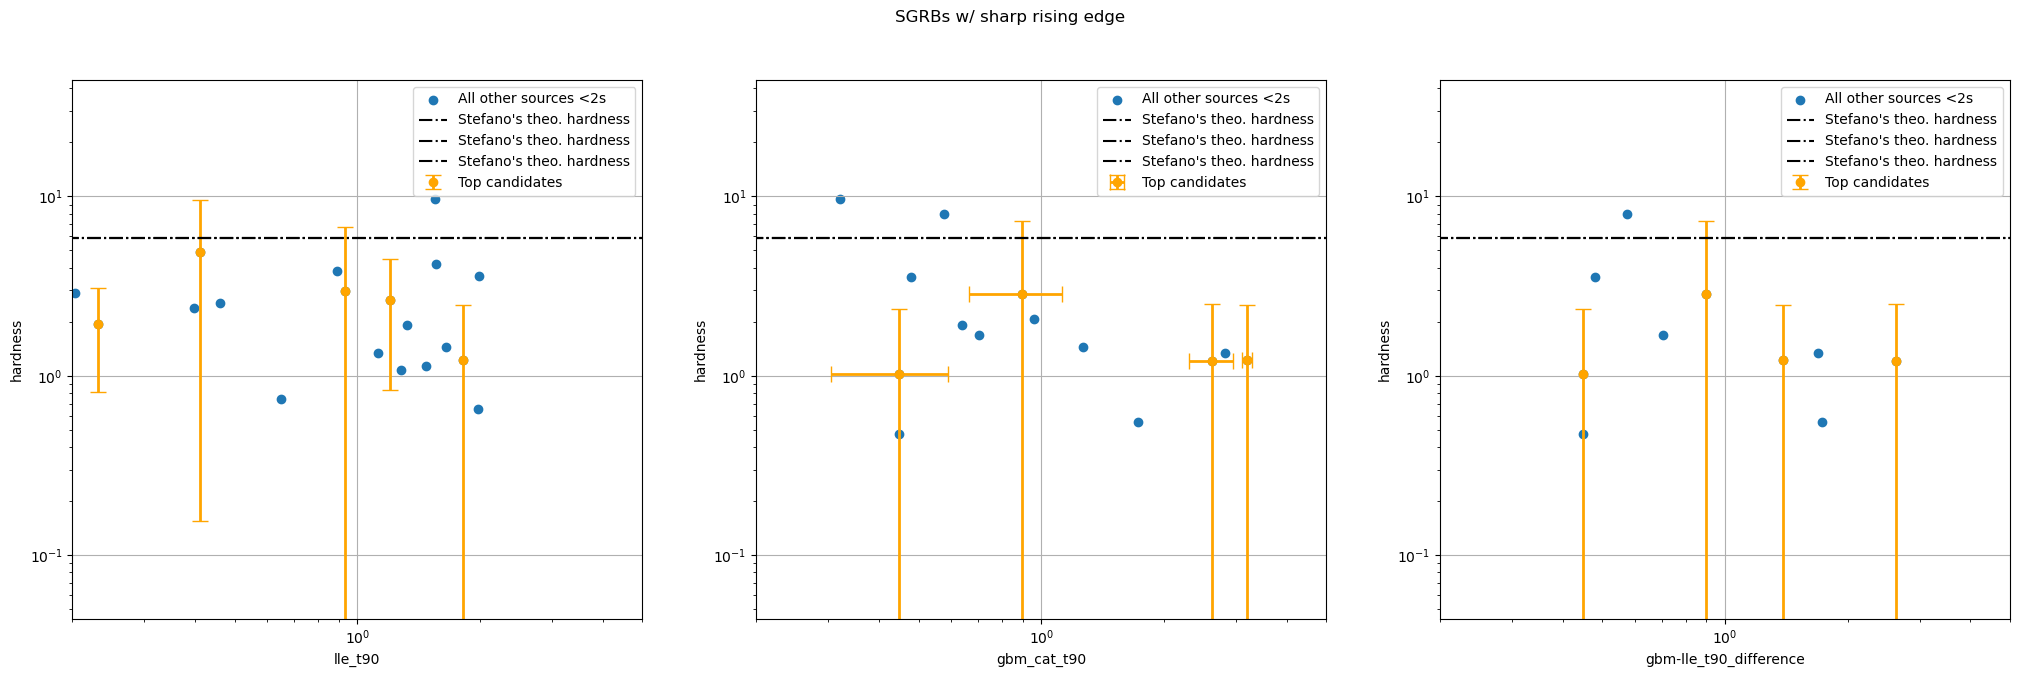

In [103]:
fig, ax_tuple = plt.subplots(1,3)

#####
ax = ax_tuple[1]

ax.errorbar(x = selection['gbm_cat_t90'], y = selection['hardness'], 
            xerr = selection['gbm_cat_t90_error'], yerr = selection['hardness_error'],
            fmt = 'o', linewidth = 2, capsize = 6,
            label = 'Top candidates', color = 'orange')



#####

ax = ax_tuple[0]

ax.errorbar(x = selection['lle_t90'], y = selection['hardness'], 
            yerr = selection['hardness_error'],
            fmt = 'o', linewidth = 2, capsize = 6,
            label = 'Top candidates', color = 'orange')

#####

ax = ax_tuple[2]

ax.errorbar(x = selection['gbm-lle_t90_difference'], y = selection['hardness'], 
            yerr = selection['hardness_error'],
            fmt = 'o', linewidth = 2, capsize = 6,
            label = 'Top candidates', color = 'orange')

#####

param = ['lle_t90','gbm_cat_t90','gbm-lle_t90_difference']
for i,ax in enumerate(ax_tuple):

    all_except = all_lt_2.query('name not in @selection')
    ax.scatter(all_except[param[i]], all_except['hardness'], label='All other sources <2s')
    
    ax.plot(np.linspace(0,all_lt_2[param].max(),100), np.ones(100)*5.9 , '-.', color = 'black',
            label = 'Stefano\'s theo. hardness')
    
    ax.grid()

    ax.set_xlabel(param[i])
    ax.set_ylabel('hardness')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlim(0.2, 5)

fig.set_figwidth(25)
fig.set_figheight(7)

fig.suptitle('SGRBs w/ sharp rising edge')

plt.show()

fig.savefig('SharpSGRBs.png', dpi=200)

In [104]:
selection.to_csv('Single_bin_<2s_sources.csv')
selection

,name,gcn_name,time,trigger_met,ra,dec,lii,bii,error_radius,redshift,...,flux_ratio,flux_ene_ratio,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_t90_difference
15,GRB170127067,b'GRB170127C ',57780.066516,5.071738e+08,338.980,-63.970,324.0439,-47.2212,0.520,0.0,...,0.000000,0.000000,0.000000,inf,NaN,NaN,NaN,NaN,-664.76001,0.128
21,GRB200219317,b'GRB200219A ',58898.317234,6.037906e+08,342.880,-60.200,326.2541,-51.1517,0.290,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.939
23,GRB160422499,b'GRB160422A ',57500.499306,4.830191e+08,42.050,-57.900,277.3920,-53.0490,0.100,0.0,...,0.000000,0.000000,0.000000,inf,NaN,NaN,NaN,NaN,-769.62000,12.288
25,GRB141222298,b'GRB141222A ',57013.297882,4.409249e+08,178.000,-57.310,294.9442,4.6371,0.080,0.0,...,0.000000,0.000000,0.000000,inf,NaN,NaN,NaN,NaN,-34.21000,1.459
33,GRB090720710,b'GRB090720B ',55032.710370,2.698022e+08,203.638,-51.198,309.7906,11.0987,0.990,0.0,...,0.200556,0.138588,0.955187,1.046916,0.158970,0.178785,1.232239,1.466619,-0.37600,10.752
36,GRB100620119,b'GRB100620A ',55367.119086,2.986951e+08,87.680,-50.660,257.9704,-30.0254,1.240,0.0,...,1.114493,1.268441,1.683925,0.593851,0.936061,1.135587,1.507555,0.533553,-3.55800,51.841
42,GRB141102536,b'GRB141102A ',56963.535868,4.366255e+08,209.070,-46.730,314.3418,14.7002,0.680,0.0,...,12.240993,9.752959,0.825804,1.210941,8.270088,10.091908,0.854502,1.296568,-3.61400,2.624
51,GRB210202841,b'GRB210202A ',59247.840637,6.339894e+08,229.810,-38.040,332.4724,16.2110,0.610,0.0,...,2.058383,2.941798,1.376886,0.726276,1.278603,2.604609,1.219066,0.569325,-0.14200,17.664
65,GRB180703949,b'GRB180703B ',58302.949201,5.523508e+08,96.920,-29.880,237.9491,-17.8795,0.440,0.0,...,0.000000,0.000000,0.000000,inf,NaN,NaN,NaN,NaN,-8.00000,1.536
66,GRB120830297,b'GRB120830A ',56169.296562,3.680032e+08,88.590,-28.790,234.1716,-24.3213,0.620,0.0,...,5.740205,3.920481,0.350574,2.852463,4.979013,6.716713,0.600617,4.463131,-0.66000,0.896


---

Do we see an afterglow signal appear in the same location as a previous SGRB?

In [105]:
#print(all_candidates['ra'].value_counts())
#print(all_candidates['dec'].value_counts())

#all_candidates[cols].loc[all_candidates['dec'] == -28.79]

# Nope!

----

- Hardness > 1
- GBM or LAT t90 in 0.2, 5s
- No Redshift


In [32]:
#select = all_candidates.query('hardness > 1').query('(gbm_cat_t90 > 0.2 and gbm_cat_t90 < 5) or (lle_t90 > 0.2 and lle_t90 < 5)')
select = pd.read_csv('H>1_T90[0.2-5]_RS=0.csv')
cols = ['name', 'ra', 'dec', 'hardness', 'lle_t90', 'gbm_cat_t90', 'gbm-lle_t90_difference', 'time_in', 'time_out']

#select[cols].to_csv('H>1_T90[0.2-5]_RS=0.csv')

select.query('(gbm_cat_t90 > 0.2 and gbm_cat_t90 < 5) and (lle_t90 > 0.2 and lle_t90 < 5)').to_csv('BOTH_T90_in_[0.2-5].csv')